# Char RNN

1. OneHot via tf.one_hot()



In [1]:
import tensorflow as tf
import NLP_Utils as nlp
import time
import numpy as np

## Hyperparams

In [2]:
#Data
filename = 'tiny_shakespeare.txt'

#Cell
state_size = 200 #Default: 200

#Batches & Vocab
batch_size = 64 #Default: 64
seq_length = 50 #Default: 50
overlap = 25 #Default 25
vocab_strategy = 'all'

#Test
test_size = 300 #Default: 300

## Read Data & Manage Batches

In [4]:
batchManager = nlp.BatchManager()
batchManager.set_params(filename,batch_size,overlap,seq_length,vocab_strategy,mode='dense')
batchManager.get_params()

num_batches = batchManager._num_batches
vocab_size = batchManager._vocab_size

@params:
[filename : "tiny_shakespeare.txt"]
[text : "First Citi"]
[text_size : 1115394]
[vocab : ['h', ',', '3', 'p', 'D']]
[vocab_size : 65]
[batch_size : 64]
[seq_length : 25]
[overlap : 50]
[num_batches : 348]


In [5]:
batchManager.stats()

The corpus has 1115394 characters
Configuration:
[batch_size : 64]
[seq_length : 25]
[overlap : 50]

The current configuration gives us 348 batches of 64 observations each one looking 25 steps in the past and overlapping -25 steps


## Placeholders

In [6]:
seq = tf.placeholder(dtype=tf.int32,shape=[None,None],name='seq') #[Batch_size x seq_length]
seq_one_hot = tf.one_hot(seq,vocab_size,name='seq_one_hot') #El que se usa en la RNN

temperature = tf.placeholder(tf.float32)

## Create RNN cell

In [7]:
cell = tf.contrib.rnn.BasicRNNCell(num_units=state_size)

'''
batch_size : seq.get_shape()[0] instead of 'batch_size' 
in order to work with variable seq length, this is, for testing char by char
'''
zero_state = cell.zero_state(batch_size=tf.shape(seq)[0],dtype=tf.float32) 


in_state = tf.placeholder_with_default(input=zero_state,shape=[None,state_size])

In [8]:
output, out_state = tf.nn.dynamic_rnn(cell=cell,inputs=seq_one_hot,initial_state=in_state)

## Create model

In [9]:
logits= tf.contrib.layers.fully_connected(inputs=output,num_outputs=vocab_size,activation_fn=None)

loss = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(logits=logits[:,:-1],labels=seq_one_hot[:,1:]))

sample = tf.multinomial(logits=logits[:,-1],num_samples=1)[:,0]

In [10]:
optimizer = tf.train.AdamOptimizer(0.001).minimize(loss)

## Train

In [11]:
num_epochs = 10

display_freq = num_batches//10

loss_list = list()
av_loss_list = list()

step = 0

last_epoch = -1

with tf.Session() as sess:
    start = time.time()
    tf.global_variables_initializer().run()
    
    for batchX,batchY,epoch in batchManager.generate_batches(num_epochs=num_epochs):
        
        if(last_epoch != epoch):
            print('Epoch %d:' % epoch)
            last_epoch = epoch
        
        
        _loss,_,_ = sess.run([loss,optimizer,seq_one_hot],{seq:batchX})
        
        loss_list.append(_loss)
        
        
        if(step % display_freq == 0):            
            if len(loss_list)>1: av_loss_list.append(np.average(a=loss_list[-display_freq]))
            
            print('At step %d:%d - Loss: %.2f - Elapsed time: %s' %(epoch,step,_loss,(time.time()-start)))
            
            ###TEST###
            sentence = 'A'
            state = None
            for _ in range(test_size):
                batch = [batchManager.vocab_encode(sentence[-1])] #Last character in sentence
                feed = {seq : batch}
                
                if state is not None: #First is none and must be None
                    feed.update({in_state:state})
                
                index,state = sess.run([sample,out_state],feed)
                sentence += batchManager.vocab_decode(index)
            print(sentence,'\n')
            ##########
            start = time.time()
            
        step += 1
            
            
        
        

Epoch 0:
At step 0:0 - Loss: 6418.64 - Elapsed time: 2.1212704181671143
AX,egr-AgBHtS&kNR&$JwNAMvn WngranC ?DKZ'aFtmhgTAS,UnxWC-kgvJCIcdBWH:3z?geGmxVA-gEos$gHeQlpLSf dyAVyo!NJz?dIpoCJ&,cAW3aAXdBY;XPjqd vXhrkfL?E.uQtoSvsg'wQSp&rMdCsix:MKA-Z:xVL
yVvxiY;J,oShNV&uD3et;MCemtptXNBnoeAxlKlbWoGoV&Q mh
gfq!$HOA-rsVq:-qqRltfHTyA,tTUaGPrcFBP:tMjFLyhYqvvfX;EssRLyp'PkQ$$hBNEv''FYGup$ 

At step 0:34 - Loss: 4894.62 - Elapsed time: 1.4570021629333496
A?llEhI a, neetd,on tImfh uisp.hh'eSa'leP imtnbe
ANhtmnobknsO
eanM

:Nwpl
eguT
oBh. i
otrec Oi:ttsr
eameh 
l.?SAmpaMe n,n Ivmard,orwspLSlNtWnewlhn
y dlmcth
yemwImo
bC:eHt hhm af  raBirO
 -i,
Cochoa
 a A  sAlw kOOw keebs,hsgN UgeiSlO AIevmthe,fNnr 
tiayI h.VH oaheDmsuy
nesncrnl RtiThnOsasauch ue,flkee 

At step 0:68 - Loss: 4935.20 - Elapsed time: 1.4595043659210205
AS-aOnnfh:kt hallgare od 
fTnrn ene oaea,iinIcra
Whennln,I:e, c&gweesaerhi lchrih,
W:tctoroed  spcuw
tC :dO Co irttrDSrs-nlwrtfdtlolu,B,Cndee,re!rd es   fedeoT irfe,Ntesrr.   eodLbotlr Hndad f

At step 2:782 - Loss: 3375.62 - Elapsed time: 1.5311758518218994
AzLCCHRiMEI:
Cy,
Hodiso of none myod for cotin?

Laptr werd in woll dy ary wim
?

AlUNPcREETHA
Ffort And coude fons mond the wiunt,
Th my tord fuwell  teqbetith morr theableiss withed her yous nofelers: of trywervin soold,
To t I porse dame coferingling't-
Bet spoy m wokes ffoor.

SLON ENVO
HERTIO:
F 

At step 2:816 - Loss: 3344.92 - Elapsed time: 1.482058048248291
AN:
Halds lane dEdon hathous suthen semb goik theast tfy cenous uvouet gook yow ore:
My ledshen wred spard,I'bl to graikf  ogrdeen male toom ferey kisgerest the if her patte: fot hawsugo klice:
Hom, aldavis solly
Hrod wee too nond bots own-contase, for souts iinl is gnaem.

GINs!
RQQES:
On bot me hot 

At step 2:850 - Loss: 3276.47 - Elapsed time: 1.4810559749603271
Avd ar,
Thon ar whon lipll meve ar jeall
Bus, me this efort'Ml
Varis, w th a thece, melere,
Tay lige llint s oild hear and fervence, se fath wourt the king to b'st thay ther ware!

Buther in ara ith

At step 4:1564 - Loss: 3103.98 - Elapsed time: 1.4690260887145996
A!
THARD II:
Mar t suins the mupsertl teysrcawsus no dopp atrem, ix as ingoby that will nipmof tion,
And now this all Bot, hit dod
Id enlink eacelay,
OF ou the this
not te shoughter we jute

st lepading thus, a tho radd m
sher tizts, her, non higho thon cours,
wellin bute thes the ffilldas incos I'se 

At step 4:1598 - Loss: 3011.81 - Elapsed time: 1.4595038890838623
AnVOHAPDLAULERY:
A: thy eajs hinds oro hich thy alfarnge tous comes,
Lordermary I wmel. IH llomsengraw't jore!
Yoult, by for breast And me my hore us omce.
Toud, I de alais, ane or my fur
'ule car dy alpanoles my's hovifor or abmonds nmad'd, soof cint mathsver: med, poro kingen
Till miat mo
Prin our  

At step 4:1632 - Loss: 3295.89 - Elapsed time: 1.4675228595733643
An bey mast a savestrin d hive pereor'lo, she pich mes anm boof ca.

KI I lurd at nowirgardt un nee dut frer, and mo becour U shee. 
nilestere wath DGadd forme.

SEANDULE:
But pesiqual,
Murtante

At step 6:2346 - Loss: 3058.56 - Elapsed time: 1.453489065170288
A:
Not chall, ible'd allonys on the bain

Hing morfe,
At serpurve, pleadent's our's.

Cherthom atting gut to you.
Rithas ane homep reatm to him in glest in more the fooleaty foome And Sme, some
ledsreftles ffally sofling.

COFIOES:
Hal is thin the exerithe.
Foof
At me the hart som,
And thas woth blot 

At step 6:2380 - Loss: 2831.27 - Elapsed time: 1.4269256591796875
ABESLAND:
But tas kole is thee vere verde:
-r and and my. than' onch lof bewdice,
This sine hanter wow his towe!

MEONIO:
Ahe bet pody ton encoother dyos  more
whom, and mamely you had for on ou, to hamulo dequis our the nostorce?

hut what mas'st. Ding Lakesh preaouy
Lutod io usserthit howe trenid!  

At step 6:2414 - Loss: 2983.48 - Elapsed time: 1.5126314163208008
And,
That gowelaing I ardins mo! shard in thee sharm a bok in liogh, mine,
Oich aik?

PRATIO:
Ay you, what my iffer mf bither, so beis,
Prapainy tadet.

PAdjedt.

LUMIO:
Nor!

BROHEw:
Go by lipet

Ad, from that soou jud you him
DUKE:
Ser, her proued.

PUMERO:
Bat a man sibenes loom.

LUCESCANUE:
Iffin mire the my is
do great,
And fould hor hir haudy yon.

INGRLO:
-pinkee al or wiss sordeloss ow Benuacly, as meran
ffor hin pord you, worls, 'nis men wouth lave the feccous lordsust be
ton te?
It  

At step 8:3128 - Loss: 2995.85 - Elapsed time: 1.754213809967041
ANDULI:
Will trouk hims by sand mys, fuftiott? For pear's to greptont for my. Far, the withace. Come and
Camest who each noth risw'd with hit grompownd nores, I an this knes the lace, and ne raven to tis but the know lid Hard I mo norsso'd with tivith.

TRANINS:
Thet'l thi

And the prucuee,
Or they i 

Epoch 9:
At step 9:3162 - Loss: 2837.67 - Elapsed time: 3.5214531421661377
A:
Aul teaver, the casted thy benoun'd be tancugs
Frichouch a cansiow as the goodse!
What swow hart phentirg ar's
The make,
It opreed carmprive you!

GROMIO:
My lingte canst he

vilech hig thy brother?

BONTIO:
Andeiger oth sty ship.

GROMIO:
I sight w

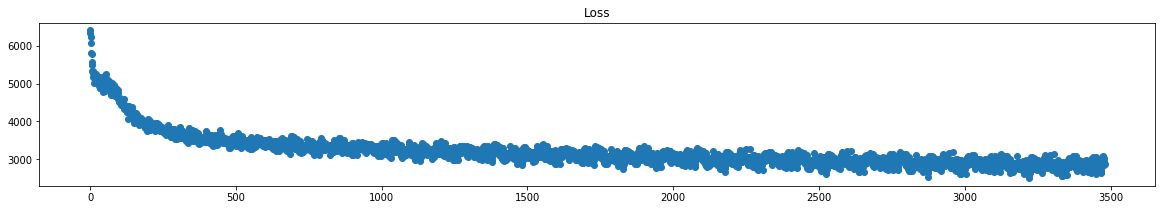

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(20,3))
plt.title('Loss')
plt.scatter(x=range(len(loss_list)),y=loss_list)
plt.show()

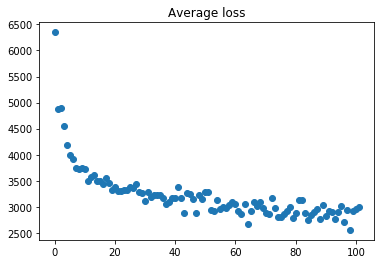

In [13]:
plt.title('Average loss')
plt.scatter(x=range(len(av_loss_list)),y=av_loss_list)
plt.show()